In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
class cnn_lstm(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(nn.Conv1d(18,256,1,stride=2),
                                   nn.ReLU(),
                                   nn.Conv1d(256,128,1,stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2),
                                #    nn.Flatten(),
                                #     nn.LSTM(51200,100),
                                   
                                    )
        self.dropout = nn.Dropout(p=0.2)
        self.lstm1 = nn.LSTM(100,100)
        self.lstm2 = nn.LSTM(100,100)
        self.biLSTM = nn.LSTM(100,100,bidirectional=True)
        self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(100,50)
        self.sigmoid  = nn.Sigmoid()
        
    def forward(self,x):
        # output, (hn,cn) = self.model(x)
        output = self.model(x)
        
        # output = self.dropout(output)
        # output, (hn,cn) = self.lstm1(output)
        # output, (hn,cn) = self.lstm2(output)
        # output, (hn,cn) = self.biLSTM(output)
        # y = self.linear1(output)
        # y_final = self.linear2(y)
        # y_final = self.sigmoid(y_final)
        
        return output
cnn = cnn_lstm()
    

In [13]:
data = pd.read_csv("collect_data/sensor_data.csv")
train = data[["timestamp_ms", "motion_detected",
    "roll_deg", "pitch_deg", "yaw_deg",
    "filtered_accel_x_(m/s²)", "filtered_accel_y_(m/s²)", "filtered_accel_z_(m/s²)",
    "filtered_gyro_x_(rad/s)", "filtered_gyro_y_(rad/s)", "filtered_gyro_z_(rad/s)",
    "accel_magnitude", "gyro_magnitude",
    "adc0", "adc1", "adc2", "adc3", "adc4"]]
test = data[["Label"]]

In [14]:
train.shape,test.shape

((200, 18), (200, 1))

In [37]:
epoch = 20
lr = 0.02

inputs = train
answer = test

optimizer = torch.optim.AdamW(cnn.parameters())
criterion = nn.MSELoss()
# with torch.autograd() as _:
for i in range(epoch):
    output = cnn(torch.tensor(train.iloc[i].to_list()).unsqueeze(1))
    
    optimizer.zero_grad()
    loss = criterion(output,torch.tensor(answer.iloc[i]))
    loss.backward()
    optimizer.step()
    
    print(f"loss = {loss}")

RuntimeError: max_pool1d() Invalid computed output size: 0

In [36]:
torch.tensor(train.iloc[i].to_list()).unsqueeze(1).size()

torch.Size([18, 1])

In [ ]:
# m = nn.Conv1d(17,256,2,stride=2)
# input = torch.randn(1, 17, 3200)
# output = m(input)
# print(output.size())
# n = nn.Conv1d(256,128,2,stride=2)
# output = n(output)
# print(output.size())
# max = nn.MaxPool1d(kernel_size=2)
# output = max(output)
# print(output.size())
# flat = nn.Flatten()
# print(flat(output).size())

torch.Size([1, 256, 1600])
torch.Size([1, 128, 800])
torch.Size([1, 128, 400])
torch.Size([1, 51200])


In [55]:
# image = np.random.random([256,256])
image = torch.rand([3,256,256])
new_image = cnn(image.unsqueeze(0))

In [57]:
new_image.size()

torch.Size([1, 1, 250, 250])

In [36]:
import torchvision
trans = torchvision.transforms.ToPILImage()

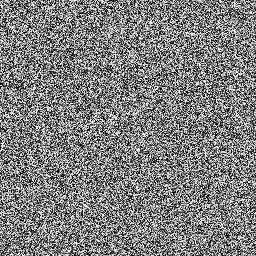

In [47]:
trans(image[0])

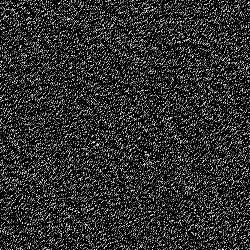

In [58]:
trans(new_image[0][0])

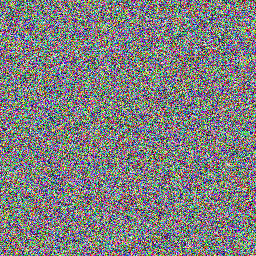

In [64]:
trans(torch.normal(image))

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
from scipy import signal
import os
from collections import Counter
import random
# os.environ["MP_DUPLICATE_LIB_OK"] = "True"

In [26]:
class lstm_linear(nn.Module):
    def __init__(self,chunk =10,sigmoid_state=True,len_input = 16,outputa = 50):
        super().__init__()
        
        h_ = 128
        
        self.dropout = nn.Dropout(p=0.3)
        self.biLSTM = nn.LSTM(chunk,h_,bidirectional=True)
        self.linear1 = nn.Linear((h_ * 2 * len_input),128)
        # self.linear2 = nn.Linear(256,128)
        self.Lazyl1 = nn.LazyLinear(128)
        self.linear2 = nn.Linear(128,outputa)
        self.sigmoid  = nn.Sigmoid()
        self.softmax  = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.sigmoid_state = sigmoid_state
    def forward(self,x):
        
        out1,(hn,cn) = self.biLSTM(x)
        
        # print(out1.size())
        b,f,o = out1.size()
        # out1 = out1.flatten()
        
        out1 = out1.reshape(b,-1)
        
        output = self.linear1((out1))
        # output = self.linear2(self.relu(output))
        y_final = self.linear2((output))
        
        if self.sigmoid_state:
            y_final = self.sigmoid(y_final)
        else:
            y_final = self.softmax(y_final)

        return y_final

In [38]:
dicta = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\Version1\model_epoch_79.pt",weights_only=False)

In [39]:
dicta

OrderedDict([('biLSTM.weight_ih_l0',
              tensor([[-0.0622, -0.1044,  0.0357,  ..., -0.0789,  0.0449, -0.0574],
                      [ 0.0298,  0.0154,  0.0958,  ...,  0.0268,  0.0469,  0.0545],
                      [-0.0370, -0.0364,  0.0024,  ...,  0.0819,  0.0041, -0.0552],
                      ...,
                      [-0.0297, -0.0744, -0.0378,  ..., -0.0812, -0.0666,  0.0007],
                      [ 0.0240, -0.0644,  0.0038,  ...,  0.0661,  0.0524, -0.0502],
                      [-0.0840, -0.0235, -0.0293,  ...,  0.0643,  0.0019,  0.0671]])),
             ('biLSTM.weight_hh_l0',
              tensor([[-0.0064,  0.0726, -0.0139,  ..., -0.0288,  0.0569,  0.0422],
                      [-0.0574, -0.0012,  0.0283,  ...,  0.0824, -0.0540, -0.0785],
                      [ 0.0803,  0.0123, -0.0471,  ..., -0.0485,  0.0022, -0.0627],
                      ...,
                      [-0.0742,  0.0329, -0.0705,  ...,  0.0136,  0.0649,  0.0197],
                      [ 0.034

In [ ]:
epoch = 100
lr = 2e-5
chunk = 50
e = 0
best_loss = 0
num_still = 0
sigoid_state = True
batch_size = 1

model = lstm_linear(chunk,sigmoid_state=sigoid_state,len_input=28,outputa=58)

In [41]:
model.load_state_dict(dicta)

<All keys matched successfully>

In [42]:
class CustomDataset(Dataset):
    def __init__(self,
                 csv_path,
                 batch=16,
                 chunk = 100,
                 vocab_path = "../Sign_Language_Detection/label.json",
                table:bool = False,
                dataframe=None):
        
        
        with open(vocab_path,"r") as f:
            compare = json.load(f)
        self.vocab = len(compare)
        
        if not table:
            self._data_csv = pd.read_csv(csv_path)
        else:
            self._data_csv = dataframe
        
        
        self._data_csv = self._data_csv[~(self._data_csv.Label.isin([ "cooldown","error_redo","break_time",]))]
        self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])
        self._data_csv = self._data_csv.drop(columns=["timestamp_ms"])
        self.train_data = self.convert_data_csv_train(self._data_csv,compare,segment=chunk,range_data=25)
        # print(len(self.train_data))
        
        print(self.train_data.size())
        fity = []
        normal =[]
        for i in self.train_data:
            # print(i[:,-1][0])
            if int(i[:,-1][-1]) == 0:
                fity.append(i)
            else:
                normal.append(i)
        # print(len(fity))
        # print(len(normal))
        fity = random.sample(fity,int(len(fity) * 0.5))
        normal.extend(fity)
        self.train_data = normal
        self.nums  = len(self.train_data)
        self.answer_transform = []
    
        self.train_data = torch.tensor([i.tolist() for i in self.train_data])
        
        
        for i in range(0,len(self.train_data)):
            # print(self.train_data)
            
            
            dummy = torch.zeros(self.vocab)
            ct = Counter(self.train_data[i][:,-1].tolist()).most_common()
            if len(ct) == 2 and ct[0][0] ==0:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[1]
            else:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[0]
            # print(Counter(self.train_data[i][:,-1].tolist()).most_common())

            dummy[int(idx)] = 1
            self.answer_transform.append(dummy)
        
        self.train_data = self.train_data[:,:,:-1]
        self.nums,self.segment,self.input = self.train_data.size()
        
        
    def __getitem__(self, index):
        
        inputs = self.train_data[index]
        answer = self.answer_transform[index]
        
        if torch.cuda.is_available():
            return inputs.to(torch.float32).movedim(1,0).to("cuda"),answer.to("cuda")
        else:
            return inputs.to(torch.float32).movedim(1,0),answer
        
        
    def __len__(self):
        return self.nums
    
    def len_answer(self):
        return self.vocab
    
    def data_info(self):
        return self.nums,self.segment,self.input,self.train_data
    
    
    
    def convert_data_csv_train(self,data,compare,segment=50,range_data = 0):

        datta = []
        previous = None
        samples = []
        abc= []
        
        
        data['group_id'] = (data['Label'] != data['Label'].shift()).cumsum()
        grouped_dfs = [g.drop(columns='group_id').values for _, g in data.groupby('group_id')]
        
        
        
        print("len(data): ",len(grouped_dfs))
        print("filter Value")
        all_data = []
        for i in tqdm(grouped_dfs,total = len(grouped_dfs)):
            if len(i) > range_data:
                all_data.append(i)


        print("pad&mean Value")

        real = []
        for i in tqdm(all_data,total = len(all_data)):
            segment = segment
            if len(i) < segment:
                tensor_df = (torch.tensor(i))
                n,b = tensor_df.size()
                padded_tensor = torch.nn.functional.pad(tensor_df, pad=(0, 0, segment-n, 0), mode='constant', value=0)
                # print(padded_tensor.size())
                real.append(padded_tensor.tolist())
            else:
                step = int(np.ceil(len(i)//segment))
                temp = []
                for k in range(segment):
                    temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
                real.append(temp)

        train_data = torch.tensor(real)
        return train_data
    
    

In [43]:
import glob
import os



test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")
# test_df  = test_df[test_df.columns[1:]]
test_dataset = CustomDataset("collect_data/20250624_131408_พชชาภา24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=test_df)
test_dataset = DataLoader(test_dataset,batch_size=1)

y_pred = []
y_true = []
prob_x = []
prob_y = []
with torch.no_grad():
    for inputs,answer in tqdm(test_dataset):
        output = model(inputs)
        prob_x.append(output)
        prob_y.append(answer)
        y_pred += (torch.argmax(output,dim=1)).tolist()
        y_true += (torch.argmax(answer,dim=1)).tolist()
            
        
from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
f1_scores = f1_score(y_true, y_pred, average="micro")
print("f1 score    ",f1_scores)
recall_scores = recall_score(y_true, y_pred, average="micro")
print("recal score ",recall_scores)
acc = accuracy_score(y_true, y_pred)
print("acc score   ",acc)
# cnf = confusion_matrix(y_true, y_pred)

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24448\1544092957.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.5688073394495413
recal score  0.5688073394495413
acc score    0.5688073394495413


In [14]:
import requests
import numpy as np
url = "http://localhost:80/predict"
payload = {
    # "feature": np.random.rand(30,29).tolist()
    "feature": np.zeros([10,29]).tolist()
}
res = requests.post(url, json=payload)
print(res)
print(res.json())

<Response [404]>
{'detail': 'Not Found'}


In [ ]:
import pandas as pd
df = pd.read_csv(r"F:\Hybridmodel-project\Sign_Language_Detection\dump\20250715_111750_DATA_INDICATOR_sensor.csv")
df = df[~(df.Label.isin(["break_time"]))].reset_index(drop=True)

In [ ]:
import requests
import numpy as np
from tqdm import tqdm
import time
from IPython.display import clear_output

url = "https://343d1078477b.ngrok-free.app/predict_hand"
step = 50

for i in tqdm(range(400,1000,step)):
    start = time.time()
    payload = {
        # "feature": np.random.rand(30,29).tolist()
        "feature": [ list(map(float, i[:-1])) for i in df.iloc[i:(i)+step].values.tolist() ] 
    }
    print(df.loc[i,"Label"])
    res = requests.post(url, json=payload)
    end = time.time()
    # print("INfernece speed",end-start)
    # clear_output(wait=True)
    print(res)
    print(res.json())

  0%|          | 0/12 [00:00<?, ?it/s]

nothing


  8%|▊         | 1/12 [00:01<00:11,  1.07s/it]

<Response [200]>
{'status': 'pass'}
เรา


 17%|█▋        | 2/12 [00:02<00:10,  1.05s/it]

<Response [200]>
{'status': 'pass'}
nothing


 25%|██▌       | 3/12 [00:02<00:08,  1.06it/s]

<Response [200]>
{'status': 'pass'}
กิน


 33%|███▎      | 4/12 [00:03<00:07,  1.13it/s]

<Response [200]>
{'status': 'pass'}
nothing


 42%|████▏     | 5/12 [00:04<00:05,  1.19it/s]

<Response [200]>
{'status': 'pass'}
ดื่ม


 50%|█████     | 6/12 [00:05<00:04,  1.21it/s]

<Response [200]>
{'status': 'pass'}
ไป


 58%|█████▊    | 7/12 [00:06<00:04,  1.22it/s]

<Response [200]>
{'status': 'pass'}
nothing


 67%|██████▋   | 8/12 [00:07<00:03,  1.10it/s]

<Response [200]>
{'status': 'pass'}
มา


 75%|███████▌  | 9/12 [00:08<00:02,  1.03it/s]

<Response [200]>
{'status': 'pass'}
nothing


 83%|████████▎ | 10/12 [00:09<00:01,  1.10it/s]

<Response [200]>
{'status': 'pass'}
ป่วย


 92%|█████████▏| 11/12 [00:09<00:00,  1.14it/s]

<Response [200]>
{'status': 'pass'}
ชอบ


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

<Response [200]>
{'status': 'pass'}


In [79]:
import torch
import torch.nn as nn
import torch.functional as f
class CNNTimeSeriesClassifier(nn.Module):
    def __init__(self, input_shape, n_classes, dropout=0.3):
        """
        CNN-based Time Series Classifier following your architecture diagram
        
        Args:
            input_shape: Tuple (sequence_length, n_features) - e.g., (121, 21)
            n_classes: Number of output classes
            dropout: Dropout rate
        """
        super(CNNTimeSeriesClassifier, self).__init__()
        
        seq_len, n_features = input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.dropout_rate = dropout
        
        # Input normalization layer
        self.normalization = nn.BatchNorm1d(n_features)
        
        # Reshape for 2D convolution: (batch, channels, height, width)
        # We'll treat sequence as height and features as width, with 1 channel
        # Input shape: (None, 1, seq_len, n_features) - e.g., (None, 1, 121, 21)
        # First Conv2D block
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after first conv+pool
        # After conv1: (None, 32, 121, 21) -> (None, 32, 119, 19) with padding=1
        # After pool1: (None, 32, 119, 19) -> (None, 32, 59, 9)
        h1, w1 = seq_len // 2, n_features // 2
        
        # Second Conv2D block
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after second conv+pool
        # After conv2: (None, 64, 59, 9) -> (None, 64, 57, 7) with padding=1
        # After pool2: (None, 64, 57, 7) -> (None, 64, 28, 3)
        h2, w2 = h1 // 2, w1 // 2
        
        # Third Conv2D block
        self.conv3 = nn.Conv2d(
            in_channels=64, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        
        # Calculate final conv output shape
        # After conv3: (None, 64, 28, 3) -> (None, 64, 26, 1) with padding=1
        h3, w3 = h2, w2
        
        # Calculate flattened size dynamically
        self.flatten_size = 64 * h3 * w3
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights properly"""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Input shape: (batch_size, seq_len, n_features)
        batch_size = x.size(0)
        
        # Normalize along feature dimension
        # Reshape for BatchNorm1d: (batch_size * seq_len, n_features)
        x_norm = x.view(-1, x.size(2))
        x_norm = self.normalization(x_norm)
        x = x_norm.view(batch_size, x.size(1), x.size(2))
        
        # Reshape for 2D convolution: (batch_size, 1, seq_len, n_features)
        x = x.unsqueeze(1)
        
        # First Conv2D + MaxPool2D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Conv2D + MaxPool2D
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Third Conv2D
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten
        x = x.view(batch_size, -1)
        
        # First Dense layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second Dense layer (output)
        x = self.fc2(x)
        
        return x
    
    def get_config(self):
        """Return model configuration for saving"""
        return {
            'input_shape': self.input_shape,
            'n_classes': self.n_classes,
            'dropout': self.dropout_rate,
            'flatten_size': self.flatten_size
        }

In [ ]:
import os



['20250715_111750_DATA_INDICATOR_sensor.csv', 'ASR_training.ipynb', 'ESP32_GENERIC-20250415-v1.25.0.bin', 'eval_all.csv', 'fastapi_docker_webapp.zip', 'female.wav', 'finetune_whsiper.ipynb', 'happy-cat-happy-happy-cat.gif', 'labels.json', 'male2.wav', 'master_Full_model.pth', 'master_onehand_cnn_timeseries_model_20250912_234622.pth', 'master_train_data.csv', 'modeling.ipynb', 'output.txt', 'README.md', 'rollback.json', 'run.py', 'signlan.ipynb', 'signlang_template copy.ipynb', 'signlang_template.ipynb', 'slave_Full_model_cnn_timeseries_model_20250913_001132.pth', 'slave_train_data.csv', 'sumat_love_this.wav', 'test_master.csv', 'test_slave_train_data.csv', 'train_all.csv', 'train_all_old.csv']


In [1]:
from PyThaiTTS.pythaitts import TTS

In [16]:
from vachanatts import TTS

text = "ฉัน กิน ข้าว"

# เสียงพูดที่รองรับ th_f_1, th_m_1, th_f_2, th_m_2

data = TTS(text,
    voice="th_f_1",
    output="output.wav",
    volume=60.0,
    speed=1.0,
    
)

for i in data:
    print(i)
    wav = i.audio_float_array
    st = i.sample_rate

<generator object Voice.synthesize at 0x0000021EFA25BB50>
AudioChunk(sample_rate=22050, sample_width=2, sample_channels=1, audio_float_array=array([-0.05603176, -0.06541467, -0.06090151, ..., -1.        ,
       -1.        , -1.        ], dtype=float32), phonemes=['t', 'ɕ', 'ʰ', 'a', '̌', 'n', ' ', ' ', 'k', 'i', 'n', ' ', ' ', 'k', 'ʰ', 'a', '̂', 'ː', 'w'], phoneme_ids=[1, 0, 32, 0, 55, 0, 145, 0, 14, 0, 164, 0, 26, 0, 3, 0, 3, 0, 23, 0, 21, 0, 26, 0, 3, 0, 3, 0, 23, 0, 145, 0, 14, 0, 163, 0, 122, 0, 35, 0, 2], phoneme_id_samples=None, phoneme_alignments=None, _audio_int16_array=None, _audio_int16_bytes=None, _phoneme_alignments=None)


In [3]:
import sys
print(sys.executable)

f:\Anaconda\envs\dataset\python.exe


In [13]:
wav, sr, spect = f5_tts.infer(
    # ref_file=str(files("f5_tts").joinpath("infer/examples/basic/basic_ref_en.wav")),
    ref_file=r"F:\Hybridmodel-project\Sign_Language_Detection\fastapi_docker_webapp\app\f5_tts\infer\examples\basic\basic_ref_en.wav",
    ref_text="some call me nature, others call me mother nature.",
    gen_text="สวัสดีคับพวกผม " + " สวัสดีคับพวกผม"
)

Converting audio...
Using custom reference text...

ref_text   some call me nature, others call me mother nature. 
gen_text 0 สวัสดีคับพวกผม สวัสดีคับพวกผม


Generating audio in 1 batches...


100%|██████████| 1/1 [01:14<00:00, 74.19s/it]

[nan nan nan ... nan nan nan] float32
